<a href="https://colab.research.google.com/github/ShubhamPrakash108/Fine-Tuning-TTS-T5-model-on-Custom-Data/blob/main/Fine_Tuning_TTS_T5_model_on_Custom_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-Tuning TTS T5 Model on Custom Data


In [2]:
!pip install transformers datasets soundfile accelerate speechbrain==0.5.16

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 630.6/630.6 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.8/117.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.2/722.2 kB 4.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requi

In [1]:
# This code logs into the Hugging Face Hub from a notebook environment.
from huggingface_hub import notebook_login

notebook_login()


Dataset link: https://huggingface.co/datasets/keithito/lj_speech

In [3]:
# This will import the dataset and resample the voices at 16kHz
from datasets import load_dataset, Audio
ds = load_dataset("keithito/lj_speech")
ds = ds.cast_column("audio", Audio(sampling_rate=16000))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.88k [00:00<?, ?B/s]

lj_speech.py:   0%|          | 0.00/3.92k [00:00<?, ?B/s]

The repository for keithito/lj_speech contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/keithito/lj_speech.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/13100 [00:00<?, ? examples/s]

In [4]:
ds

DatasetDict({
    train: Dataset({
        features: ['id', 'audio', 'file', 'text', 'normalized_text'],
        num_rows: 13100
    })
})

In [5]:
# Split the dataset and keep 50% of the data(more data will take more)
ds_split = ds["train"].train_test_split(test_size=0.5, seed=42)
ds = ds_split["test"]

# Print the first few samples to verify
ds

Dataset({
    features: ['id', 'audio', 'file', 'text', 'normalized_text'],
    num_rows: 6550
})

In [ ]:
# Randomly selects and plays an audio sample from the LJ Speech dataset.
from IPython.display import Audio
import random

sample_index = random.randint(0, len(ds) - 1)
sample = ds[sample_index]

print("Audio data:", sample["audio"])
print("Text data:", sample["text"])
print("Normalized Text data:", sample["normalized_text"])

audio_data = sample["audio"]["array"]
sampling_rate = sample["audio"]["sampling_rate"]

Audio(data=audio_data, rate=sampling_rate)

In [7]:
import os
import torch
from speechbrain.pretrained import EncoderClassifier
from transformers import SpeechT5Processor
from dataclasses import dataclass
from typing import Any, Dict, List, Union

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [8]:
# Load SpeechT5 processor and tokenizer

checkpoint = "microsoft/speecht5_tts"
processor = SpeechT5Processor.from_pretrained(checkpoint)

# Load the pre-trained speaker model from SpeechBrain
spk_model_name = "speechbrain/spkrec-xvect-voxceleb"

device = "cuda" if torch.cuda.is_available() else "cpu"

speaker_model = EncoderClassifier.from_hparams(
    source=spk_model_name,
    run_opts={"device": device},
    savedir=os.path.join("/tmp", spk_model_name),
)


preprocessor_config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/232 [00:00<?, ?B/s]

spm_char.model:   0%|          | 0.00/238k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/40.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

hyperparams.yaml:   0%|          | 0.00/2.04k [00:00<?, ?B/s]

embedding_model.ckpt:   0%|          | 0.00/16.9M [00:00<?, ?B/s]

mean_var_norm_emb.ckpt:   0%|          | 0.00/3.20k [00:00<?, ?B/s]

classifier.ckpt:   0%|          | 0.00/15.9M [00:00<?, ?B/s]

label_encoder.txt:   0%|          | 0.00/129k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/speechbrain/utils/checkpoints.py:147: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(path, map_location=device), strict=Fal

In [9]:
# Define the function to create speaker embeddings
def create_speaker_embedding(waveform):
    with torch.no_grad():
        speaker_embeddings = speaker_model.encode_batch(torch.tensor(waveform))
        speaker_embeddings = torch.nn.functional.normalize(speaker_embeddings, dim=2)
        speaker_embeddings = speaker_embeddings.squeeze().cpu().numpy()
    return speaker_embeddings


In [10]:
# Function to prepare the dataset for training
def prepare_dataset(example):
    audio = example["audio"]
    # Preprocess text and audio
    example = processor(
        text=example["normalized_text"],
        audio_target=audio["array"],
        sampling_rate=audio["sampling_rate"],
        return_attention_mask=False,
    )
    # Strip off the batch dimension
    example["labels"] = example["labels"][0]

    # Create speaker embeddings using SpeechBrain
    example["speaker_embeddings"] = create_speaker_embedding(audio["array"])

    return example


In [11]:
# Apply the function to the dataset
ds = ds.map(prepare_dataset, remove_columns=ds.column_names)

# Filter out examples with too long input sequences (e.g., longer than 200 tokens)
def is_not_too_long(input_ids):
    input_length = len(input_ids)
    return input_length < 200

ds = ds.filter(is_not_too_long, input_columns=["input_ids"])

# Split the dataset into training and testing sets (90% training, 10% testing)
ds = ds.train_test_split(test_size=0.1)


Map:   0%|          | 0/6550 [00:00<?, ? examples/s]

Filter:   0%|          | 0/6550 [00:00<?, ? examples/s]

In [12]:
# Define a custom data collator with padding for batching
@dataclass
class TTSDataCollatorWithPadding:
    processor: Any

    def __call__(
        self, features: List[Dict[str, Union[List[int], torch.Tensor]]]
    ) -> Dict[str, torch.Tensor]:
        input_ids = [{"input_ids": feature["input_ids"]} for feature in features]
        label_features = [{"input_values": feature["labels"]} for feature in features]
        speaker_features = [feature["speaker_embeddings"] for feature in features]

        # Collate the inputs and targets into a batch
        batch = processor.pad(
            input_ids=input_ids, labels=label_features, return_tensors="pt"
        )

        # Replace padding with -100 to ignore loss correctly
        batch["labels"] = batch["labels"].masked_fill(
            batch.decoder_attention_mask.unsqueeze(-1).ne(1), -100
        )

        # Not used during fine-tuning
        del batch["decoder_attention_mask"]

        # Round down target lengths to multiple of reduction factor (if applicable)
        if model.config.reduction_factor > 1:
            target_lengths = torch.tensor(
                [len(feature["input_values"]) for feature in label_features]
            )
            target_lengths = target_lengths.new(
                [
                    length - length % model.config.reduction_factor
                    for length in target_lengths
                ]
            )
            max_length = max(target_lengths)
            batch["labels"] = batch["labels"][:, :max_length]

        # Add speaker embeddings
        batch["speaker_embeddings"] = torch.tensor(speaker_features)

        return batch


In [13]:
# Instantiate the data collator
data_collator = TTSDataCollatorWithPadding(processor=processor)


In [14]:
from transformers import SpeechT5Processor

checkpoint = "microsoft/speecht5_tts"
processor = SpeechT5Processor.from_pretrained(checkpoint)

In [15]:
from transformers import SpeechT5ForTextToSpeech

model = SpeechT5ForTextToSpeech.from_pretrained(checkpoint)

config.json:   0%|          | 0.00/2.06k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/585M [00:00<?, ?B/s]

In [16]:
from functools import partial
from transformers import Seq2SeqTrainingArguments
model.config.use_cache = False
model.generate = partial(model.generate, use_cache=True)

training_args = Seq2SeqTrainingArguments(
    output_dir="TTS-T5_finetuned",
    per_device_train_batch_size=4,
    gradient_accumulation_steps=8,
    learning_rate=1e-4,
    warmup_steps=100,
    max_steps=500,
    gradient_checkpointing=True,
    fp16=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=2,
    save_steps=100,
    eval_steps=100,
    logging_steps=25,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    greater_is_better=False,
    label_names=["labels"],
    push_to_hub=True,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [17]:
from datasets import DatasetDict

dataset = DatasetDict({
    "train": ds["train"].train_test_split(test_size=0.1)["train"],
    "test": ds["train"].train_test_split(test_size=0.1)["test"],
})


In [18]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    data_collator=data_collator,
    tokenizer=processor,
)
trainer.train()

trainer.push_to_hub()

model.safetensors:   0%|          | 0.00/585M [00:00<?, ?B/s]

<ipython-input-18-f1beb1c0fb54>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss,Validation Loss
100,0.468400,0.407582
200,0.432600,0.400492
300,0.425700,0.384106
400,0.416000,0.378468
500,0.414800,0.373901


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:2817: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 1876}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


CommitInfo(commit_url='https://huggingface.co/shubhamprakash/TTS-T5_finetuned/commit/45160c21f609f52d15c00f7c44be5e9c6f7537ea', commit_message='End of training', commit_description='', oid='45160c21f609f52d15c00f7c44be5e9c6f7537ea', pr_url=None, repo_url=RepoUrl('https://huggingface.co/shubhamprakash/TTS-T5_finetuned', endpoint='https://huggingface.co', repo_type='model', repo_id='shubhamprakash/TTS-T5_finetuned'), pr_revision=None, pr_num=None)

In [19]:
# Loading the fine tuned model
model = SpeechT5ForTextToSpeech.from_pretrained(
    "shubhamprakash/TTS-T5_finetuned"
)

config.json:   0%|          | 0.00/2.10k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/578M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

In [21]:
# Load the processor, model, and vocoder
from transformers import SpeechT5HifiGan
import soundfile as sf

vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")

inputs = processor(text="Hi, my name is Shubham Prakash.", return_tensors="pt")

embeddings_dataset = load_dataset("Matthijs/cmu-arctic-xvectors", split="validation")
speaker_embeddings = torch.tensor(embeddings_dataset[7306]["xvector"]).unsqueeze(0)

speech = model.generate_speech(inputs["input_ids"], speaker_embeddings, vocoder=vocoder)

sf.write("output_speech.wav", speech.numpy(), samplerate=16000)


config.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/50.7M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

cmu-arctic-xvectors.py:   0%|          | 0.00/1.36k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/50.6M [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/21.3M [00:00<?, ?B/s]

Generating validation split:   0%|          | 0/7931 [00:00<?, ? examples/s]

In [22]:
display(Audio("/content/output_speech.wav", autoplay=True))

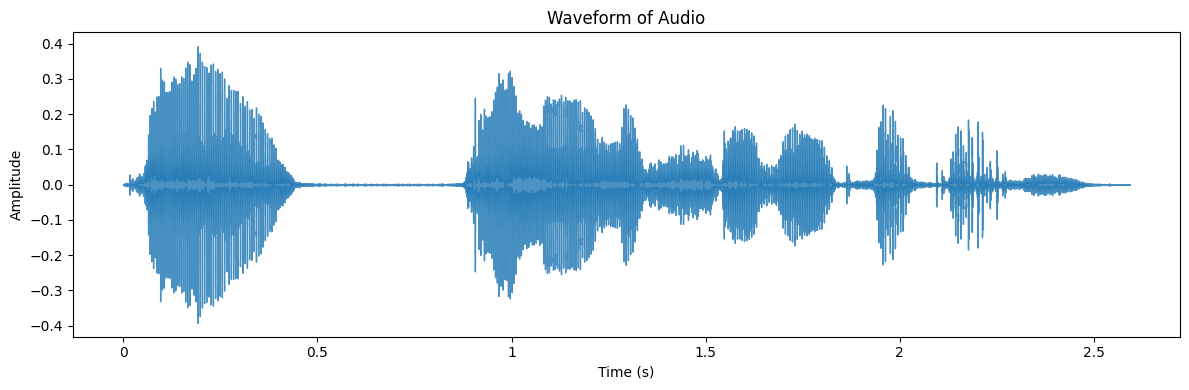

In [23]:
# Displaying the waveform
import librosa
import librosa.display
import matplotlib.pyplot as plt

audio_file = "/content/output_speech.wav"

y, sr = librosa.load(audio_file, sr=None)

plt.figure(figsize=(12, 4))
librosa.display.waveshow(y, sr=sr, alpha=0.8)
plt.title("Waveform of Audio")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

# Play the audio
Audio(audio_file, autoplay=True)
